In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage
import scipy
import os
import scipy.ndimage
import datetime
import random as rd
from skimage.transform import SimilarityTransform, warp
from skimage import transform
from pylab import *
from scipy import signal
from scipy import *
from PIL import Image
import keras 
from keras.datasets import mnist
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


In [2]:
def ReadImage(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [3]:
def ShowImage(img, cmap=None):
    fig = plt.figure(dpi=150)
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(img, cmap=cmap)

In [4]:
def GetContours(canny_edges):
    img, contours, hierarchy = cv2.findContours(canny_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
    return contours

In [5]:
def ExtractSudokuCells(img, img_gray):
    edges = cv2.Canny(img_gray, 50, 100)
    ShowImage(edges,cmap=plt.cm.gray)

    # generate contours
    contours = GetContours(edges)
    img_cont = cv2.drawContours(np.copy(img), contours, -1, (0, 255, 0), 3)
    ShowImage(img_cont)

    '''
    # draw contours on empty canvas
    pure_cont = cv2.drawContours(np.zeros(img.shape).astype(np.uint8), contours, -1, (0, 255, 0), 3)
    for p in contours[0]:
        x, y = p[0][1], p[0][0]
        pure_cont[x-2:x+3, y-2:y+3, 0] = np.ones((5,5)).astype(np.uint8) * 255
        pure_cont[x-2:x+3, y-2:y+3, 1] = np.zeros((5,5)).astype(np.uint8)

    x, y = contours[0][0][0][1], contours[0][0][0][0]
    pure_cont[x-2:x+3, y-2:y+3, 2] = np.ones((5,5)).astype(np.uint8) * 255
    pure_cont[x-2:x+3, y-2:y+3, 1] = np.zeros((5,5)).astype(np.uint8)
    pure_cont[x-2:x+3, y-2:y+3, 0] = np.zeros((5,5)).astype(np.uint8)
    ShowImage(pure_cont)
    '''

    # Get poly corners from contours
    for i in range(1, 1000):
        epsilon = i * 0.001 * cv2.arcLength(contours[0], True)
        approx = cv2.approxPolyDP(contours[0], epsilon, True)
        if len(approx) <= 4:
            approx = np.array([n[0] for n in approx]).astype(np.float32)
            break

    x_idx = np.argsort(approx[:, 0])
    first_2_x = approx[x_idx[:2], :]
    y_idx = np.argsort(first_2_x[:, 1])
    p00, p01 = x_idx[y_idx]
    last_2_x = approx[x_idx[2:], :]
    y_idx = np.argsort(last_2_x[:, 1]) + 2
    p10, p11 = x_idx[y_idx]

    approx = approx[[p00, p10, p11, p01], :]

    # solve transformation
    h = np.array([[0, 0], [449, 0], [449, 449], [0, 449]]).astype(np.float32)
    transform = cv2.getPerspectiveTransform(approx, h)
    warp = cv2.warpPerspective(img, transform, (450, 450))
    ShowImage(warp)

    # Get cells
    cells = []
    for i in range(9):
        for j in range(9):
            cells.append(cv2.cvtColor(warp[i*50:(i+1)*50, j*50:(j+1)*50], cv2.COLOR_BGR2GRAY))

    return cells

In [6]:
def DFS(cells, row, col, grid, row_idx=0):
    for i in range(row_idx, 9):
        for j in range(9):
            if cells[i][j] == 0:
                grid_x, grid_y = i // 3, j // 3
                next_row_idx = row_idx + 1 if j == 8 else row_idx
                for k in range(1, 10):
                    if not row[i][k] and not col[j][k] and not grid[grid_x][grid_y][k]:
                        row[i][k] = True
                        col[j][k] = True
                        grid[grid_x][grid_y][k] = True
                        cells[i][j] = k

                        if DFS(cells, row, col, grid, next_row_idx):
                            return True

                        row[i][k] = False
                        col[j][k] = False
                        grid[grid_x][grid_y][k] = False
                        cells[i][j] = 0
                return False
    return True

In [7]:
def SolveSudoku(cells):
    row = np.zeros((10, 10), dtype=np.bool_)
    col = np.zeros((10, 10), dtype=np.bool_)
    grid = np.zeros((3, 3, 10), dtype=np.bool_)

    for i in range(9):
        for j in range(9):
            if arr[i][j] != 0:
                if row[i][arr[i][j]] or col[j][arr[i][j]] or grid[i // 3][j // 3][arr[i][j]]:
                    return False
                row[i][arr[i][j]] = True
                col[j][arr[i][j]] = True
                grid[i // 3][j // 3][arr[i][j]] = True

    return DFS(cells, row, col, grid)

In [8]:
def RecognizeDigit(model_path, cells):
    model = load_model(model_path)

    x = np.array(cells) / 255.0
    x = transform.resize(x, (len(cells), 28, 28, 1))

    x = np.where(x > 0.2, 1.0, 0.0)
    for i in range(x.shape[0]):
        a, b = x.shape[1], x.shape[2]
        for j in range(3):
            x[i, j, :, 0] = 1.0
            x[i, a - j - 1, :, 0] = 1.0
            x[i, :, j, 0] = 1.0
            x[i, :, b - j - 1, 0] = 1.0

    plt.imshow(x[3, :, :, 0], cmap='gray')
    plt.show()
    plt.imshow(x[4, :, :, 0], cmap='gray')
    plt.show()
    fig = plt.figure(dpi=150)
    for i in range(9):
        for j in range(9):
            a = fig.add_subplot(9, 9, i * 9 + j + 1)
            plt.imshow(x[i * 9 + j, :, :, 0], cmap='gray')
    plt.show()

    # predicting
    results = model.predict(x)
    results = np.argmax(results, axis=1)

    for i in range(x.shape[0]):
        m = np.mean(x[i, 4:24, 4:24, 0])
        if m > 0.9 or m < 0.1:
            results[i] = 0
    return results

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


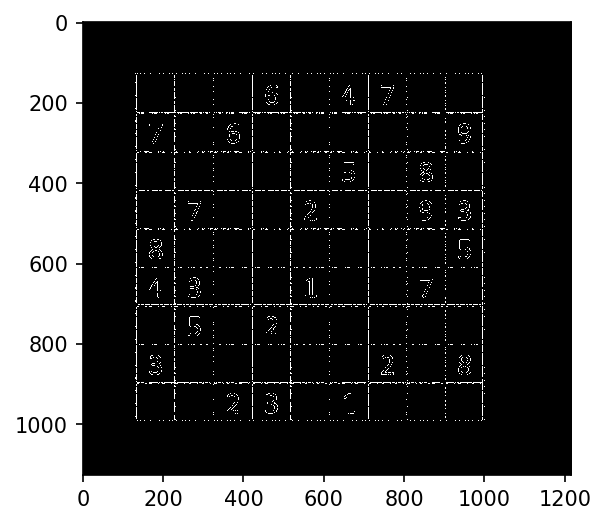

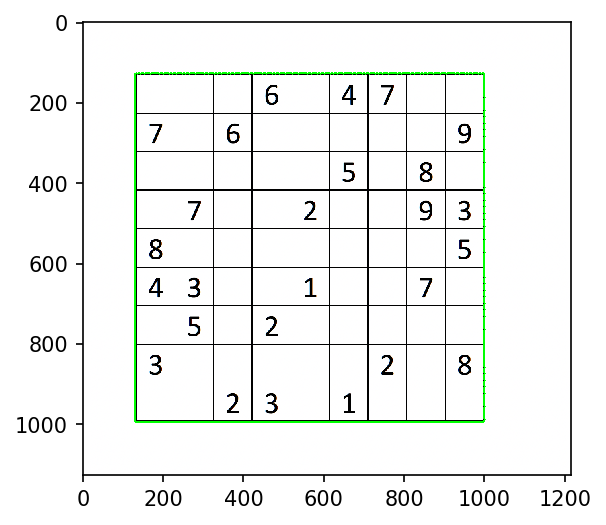

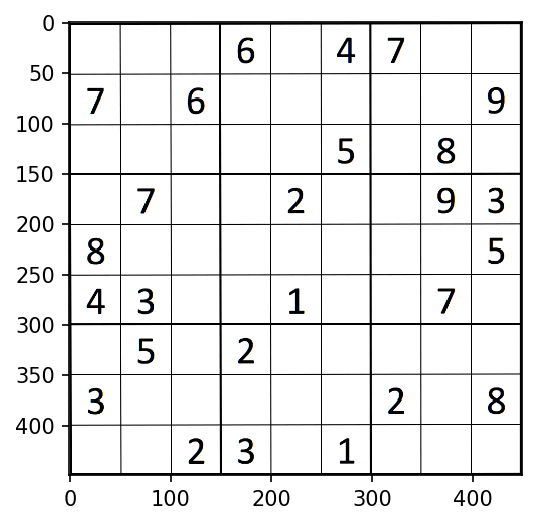

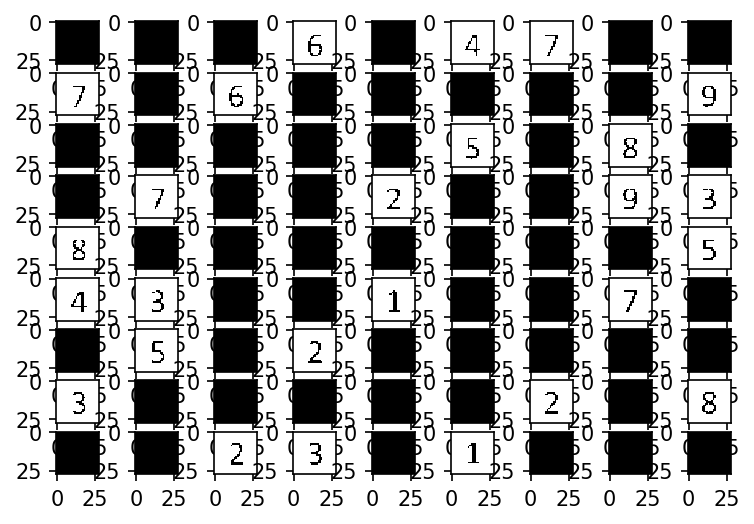

0 0 0 8 0 0 0 0 0 
0 0 8 0 0 0 0 0 0 
0 0 0 0 0 0 0 8 0 
0 0 0 0 0 0 0 8 0 
8 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 
0 0 0 8 0 0 0 0 0 
0 0 0 0 0 0 8 0 8 
0 0 8 8 0 0 0 0 0 
5 8 3 6 9 4 7 2 1 
7 1 6 8 3 2 5 4 9 
2 9 4 1 7 5 3 8 6 
6 7 1 5 2 8 4 9 3 
8 2 9 7 4 3 1 6 5 
4 3 5 9 1 6 8 7 2 
1 5 8 2 6 7 9 3 4 
3 6 7 4 5 9 2 1 8 
9 4 2 3 8 1 6 5 7 


In [9]:
if __name__ == '__main__':
    filepath = 'data/sudoku/sudoku2.png'
    img, img_gray = ReadImage(filepath)

    cells = ExtractSudokuCells(img, img_gray)
    '''
    fig = plt.figure(dpi=150)
    for i in range(9):
        for j in range(9):
            a = fig.add_subplot(9, 9, i * 9 + j + 1)
            plt.imshow(cells[i * 9 + j], cmap='gray')
    plt.show()
    '''

    arr = RecognizeDigit('data/my_model.h5', cells)
    for i in range(9):
        for j in range(9):
            print(arr[i * 9 + j], end=' ')
        print()

    #### TEST Sudoku Solver ####
    arr = [
        [0, 0, 0, 6, 0, 4, 7, 0, 0],
        [7, 0, 6, 0, 0, 0, 0, 0, 9],
        [0, 0, 0, 0, 0, 5, 0, 8, 0],
        [0, 7, 0, 0, 2, 0, 0, 9, 3],
        [8, 0, 0, 0, 0, 0, 0, 0, 5],
        [4, 3, 0, 0, 1, 0, 0, 7, 0],
        [0, 5, 0, 2, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 0, 2, 0, 8],
        [0, 0, 2, 3, 0, 1, 0, 0, 0],
    ]
    ############################

    flag = SolveSudoku(arr)
    if not flag:
        print('No solution')
    else:
        for i in range(9):
            for j in range(9):
                print(arr[i][j], end=' ')
            print()